In [1]:
%matplotlib inline

import h5py
import glob
import collections
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
def plot_sweep(
        pattern, 
        key='pos_ce',
        agg_fn=np.min,
        comp=lambda a,b: a<b,
        modes=['with_adapt', 'without_adapt', 'target_only'],
        hyperparam_keys=[]):
    
    # separate the filepaths by mode
    filepaths = glob.glob(pattern)
    mode_filepaths = collections.defaultdict(list)
    for filepath in filepaths:
        for mode in modes:
            if mode in filepath:
                mode_filepaths[mode].append(filepath)
    
    mode_values = collections.defaultdict(list)
    all_mode_values = collections.defaultdict(lambda: collections.defaultdict(list))
    hyperparams = collections.defaultdict(lambda: collections.defaultdict(dict))
    samples_sizes = set()
    for mode in modes:
        worst_value = -agg_fn([np.inf, -np.inf])
        best_values = collections.defaultdict(lambda: worst_value)
        for filepath in mode_filepaths[mode]:
            res = np.load(filepath).item()
            cur_value = agg_fn(res['val'][key])
            filename = os.path.split(filepath)[-1]
            sample_size = int(filename[:filename.index('_')])
            samples_sizes.add(sample_size)
            if comp(cur_value, best_values[sample_size]):
                best_values[sample_size] = cur_value
                for k in hyperparam_keys:
                    hyperparams[mode][sample_size][k] = res[k]
                    
            all_mode_values[mode][sample_size].append(cur_value)
        
        sorted_keys = sorted(best_values.keys())
        for k in sorted_keys:
            mode_values[mode].append(best_values[k])

    return mode_values, list(sorted(samples_sizes)), hyperparams, all_mode_values

In [8]:
pattern = '../../data/datasets/nov/hyperparam_search/*.npy'
key = 'tgt_loss'
title = 'Negative Log Likelihood of Positive Samples'
xlabel = 'Number of Positive Events in Target Training Data'
ylabel = 'Negative Log Likelihood'
modes = ['with_adapt', 'without_adapt', 'target_only']
hyperparam_keys = ['encoder_size','classifier_size','dropout_keep_prob', 'learning_rate']
results, sample_sizes, hyperparams, all_results = plot_sweep(
    pattern, 
    key=key,
    modes=modes,
    hyperparam_keys=hyperparam_keys
)

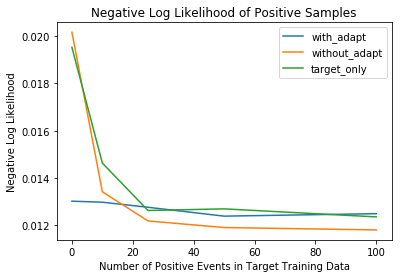

In [9]:
for mode in modes:
    plt.plot(sample_sizes, results[mode], label=mode)
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend()

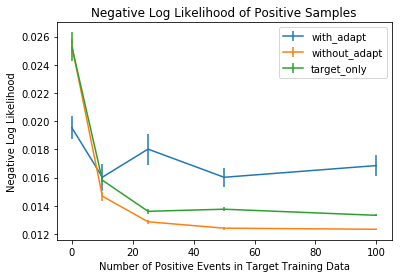

In [10]:
mode_means = dict()
mode_std_errs = dict()
for mode in modes:    
    means, std_errs = [], []
    for sample_size in sample_sizes:
        mean = np.mean(all_results[mode][sample_size])
        means.append(mean)
        std_err = np.std(all_results[mode][sample_size]) / np.sqrt(len(all_results[mode][sample_size]))
        std_errs.append(std_err)
    plt.errorbar(sample_sizes, means, yerr=std_errs, label=mode)
    mode_means[mode] = means
    mode_std_errs[mode] = std_errs

plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend()

In [11]:
for sample_size in sample_sizes:
    print(hyperparams['with_adapt'][sample_size])

{'classifier_size': (64,), 'encoder_size': (512, 256, 128, 64), 'dropout_keep_prob': 0.98994974874371855, 'learning_rate': 0.00051155778894472362}
{'classifier_size': (64, 64), 'encoder_size': (512, 256, 128, 64), 'dropout_keep_prob': 0.9346733668341709, 'learning_rate': 0.00038944723618090449}
{'classifier_size': (), 'encoder_size': (512, 256, 128, 64), 'dropout_keep_prob': 0.85929648241206036, 'learning_rate': 0.0009909547738693467}
{'classifier_size': (), 'encoder_size': (256, 128, 64), 'dropout_keep_prob': 0.90201005025125625, 'learning_rate': 0.0003487437185929648}
{'classifier_size': (), 'encoder_size': (512, 256, 128, 64), 'dropout_keep_prob': 0.80150753768844218, 'learning_rate': 0.00075125628140703521}


In [12]:
output_filepath = '../../data/results/data/da_sim_{}.h5'.format(key)
f = h5py.File(output_filepath, 'w')
f.create_dataset('sample_sizes', data=sample_sizes)

for mode in modes:
    g = f.create_group(mode)
    g.create_dataset('means', data=mode_means[mode])
    g.create_dataset('std_errs', data=mode_std_errs[mode])
f.close()